Data is at ../Gaia_var.fits

Data is retrieved using the ```ellipsoid.py``` script

### Import Packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d

import cubehelix

In [2]:
import matplotlib
from mpl_toolkits.mplot3d import axes3d   
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

#### Color Maps

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

#### Create SkyCoord Object for SN1987A with RA, Dec, Distance

In [4]:
# Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [5]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.2697417)>
51400.0 pc


#### Read in Gaia Data and Turn Into SkyCoord Objects

In [6]:
Gaia_file = '../Gaia_var.fits'
Gaia = Table.read(Gaia_file, format='fits')

In [7]:
c1 = SkyCoord(ra = Gaia['ra'],
              dec = Gaia['dec'],
              distance = Gaia['dist'],
              frame = 'icrs')
# in degrees, degrees, kpc

In [8]:
c1

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(280.20148696, -28.96359515, 1140.4207 ),
     (280.1997296 , -28.93761617, 4335.039  ),
     (280.2400282 , -28.92396486,  798.62897), ...,
     (132.77615122, -17.88714725, 1105.3617 ),
     (132.67013265, -17.93061131,  634.1305 ),
     (132.73791589, -17.85892756, 1416.8866 )]>

In [9]:
c1[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (280.20148696, -28.96359515, 1140.4207)>

In [10]:
len(Gaia)

5942077

#### Time Since Event Was Observed

In [11]:
t1 = Time.now()
dt = t1-t0

dt.to('year')

<Quantity 35.35096363 yr>

#### Ellipsoid Geometry

In [12]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center (half the distance from Earth to SN1987A, the two foci)
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # semi-major axis of ellipse
# first term is the distance along the major axis beyond Earth -- it is half the distance light would travel in the time since the event was observed
     
print(a-c) # should be half the value of dt above, but in lyr

17.675481812722865 lyr


#### Gaia Star Geometric Properties

In [13]:
d1 = (Gaia['dist']) # dist to Gaia stars (in kpc)

d2 = c1.separation_3d(c0) # dist from all Gaia stars to SN 1987A

In [14]:
# Q1. Has the star seen SN1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES
# left side is the distance from the star to SN 1987A
# right side is the distance from SN 1987A to Earth plus the extra distance light has travelled since it was observed


# Q2. Is it within the SETI Ellipsoid?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES
# left side is distance from SN 1987A to star plus distance from star to Earth
# right side is the major axis (the sum of the two focal point distances for all points on an ellipse/ellipsoid is equal to the major axis length)

# Q3. Is it within some tolerance of being ON the ellipse?
# Either a range of distance of time
tol = 0.1 # lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol
# check if sum of focal point distances minus the major axis diameter is within the interval (-tol, tol)

In [15]:
print('Total number of variable stars (with epoch photometry) in Gaia:', len(d1))
print('Number of variable stars that have seen SN1987A:', sum(SNYES))
print('Number of variable stars that have not seen SN1987A:', sum(SNNO))
print('Number of variable stars inside SETI Ellipsoid:', sum(EYES))
print('Number of variable stars within ' + str( tol ) + ' lyr of ellipsoid:', sum(OYES))

Total number of variable stars (with epoch photometry) in Gaia: 5942077
Number of variable stars that have seen SN1987A: 3198470
Number of variable stars that have not seen SN1987A: 2743607
Number of variable stars inside SETI Ellipsoid: 34849
Number of variable stars within 0.1 lyr of ellipsoid: 146


In [18]:
print('Fraction of variable stars that have seen SN1987A:', sum(SNYES) / len(d1))
print('Fraction of variable stars that have not seen SN1987A:', sum(SNNO) / len(d1))
print('Fraction of variable stars inside SETI Ellipsoid:', sum(EYES) / len(d1))

Fraction of variable stars that have seen SN1987A: 0.5382747480384384
Fraction of variable stars that have not seen SN1987A: 0.4617252519615616
Fraction of variable stars inside SETI Ellipsoid: 0.0058647843169989215


These are lower fractions to those from Gaia variable stars, which is expected since the range of distances is much larger

## Plotting

Text(0.5, 0, 'Z (pc)')

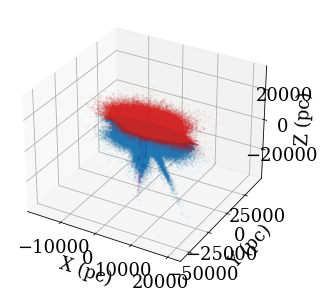

In [19]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Gaia['x'][SNNO], Gaia['y'][SNNO], Gaia['z'][SNNO], c='C3', s=1, alpha=0.05, rasterized=True)
ax.scatter(Gaia['x'][SNYES], Gaia['y'][SNYES], Gaia['z'][SNYES], c='C0', s=1, alpha=0.05, rasterized=True)
ax.scatter(Gaia['x'][EYES], Gaia['y'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(Gaia['x'][OYES], Gaia['y'][OYES], Gaia['z'][OYES], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

(-50000.0, 50000.0)

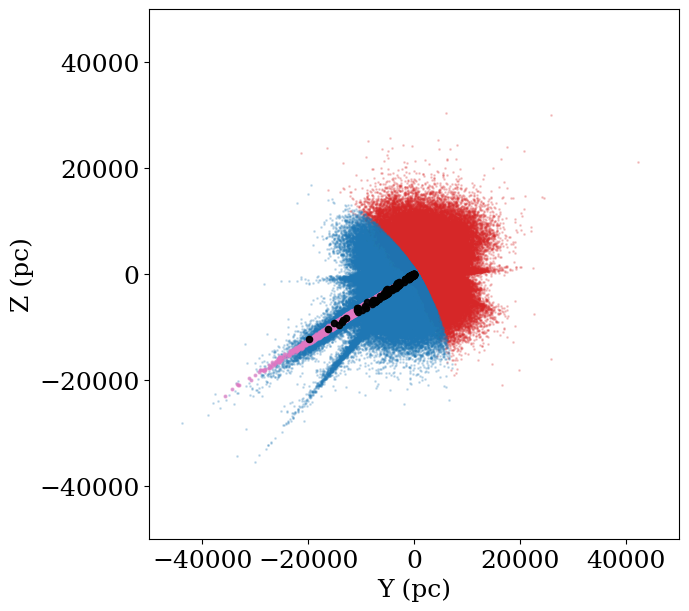

In [26]:
fig = plt.figure(dpi=100,figsize=(8,6), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()

ax.set_aspect('equal', adjustable='box')

ax.scatter(Gaia['y'][SNNO], Gaia['z'][SNNO], c='C3', s=1, alpha=0.2, rasterized=True)
ax.scatter(Gaia['y'][SNYES], Gaia['z'][SNYES], c='C0', s=1, alpha=0.2, rasterized=True)
ax.scatter(Gaia['y'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
ax.scatter(Gaia['y'][OYES], Gaia['z'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

ax.set_xlabel('Y (pc)')
ax.set_ylabel('Z (pc)')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)

## Another way of looking at it in terms of time

In [27]:
# The ellipsoid is d2 + r = 2c + time (focal point distances equals major axis)
# So we can rewrite this as time = d2 + r - 2c

etime = d2.to('lyr') + d1.to('lyr') - (2*c)

x10 = (np.abs(Gaia['x']) < 25) & (np.abs(Gaia['y']) < 1500) & (np.abs(Gaia['z']) < 1500) # 'slice' through Gaia, with galactocentric |X| < 10 pc

In [29]:
np.ma.sum(x10)

102386

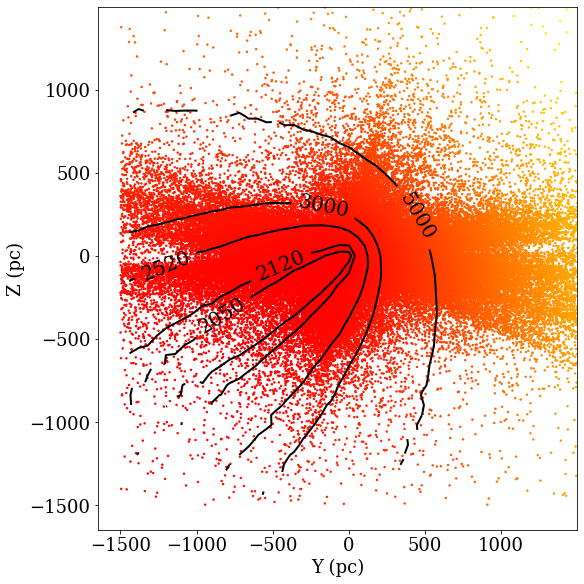

In [30]:
H, xe, ye, bn = binned_statistic_2d(Gaia['y'][x10], Gaia['z'][x10],
                                    values = etime[x10].value + t0.decimalyear, 
                                    statistic='mean', bins=50) # mean binning for contours
XX, YY = np.meshgrid(xe, ye)


plt.figure(figsize=(8,8), constrained_layout=True)
plt.scatter(Gaia['y'][x10], Gaia['z'][x10],
            c=(etime[x10].value + t0.decimalyear), cmap=plt.cm.autumn, rasterized=True, s=2)
# contour (c) is the time (d2 + r - 2c) plus the time when the event was observed on Earth (1987)


cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=2, levels=[2050, 2120, 2520, 3000, 5000]) # binned contours
plt.clabel(cs, fontsize=20)



plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
#plt.xlim(-130, 130)
#plt.ylim(-130,130)
plt.show()

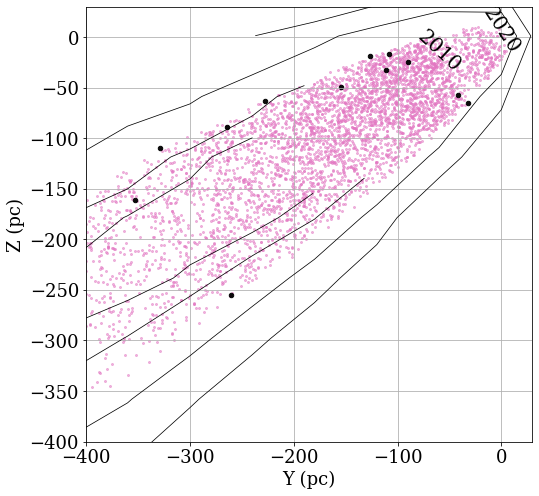

In [31]:
plt.figure(figsize=(8,8))

plt.scatter(Gaia['y'][EYES & x10], Gaia['z'][EYES & x10], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(Gaia['y'][OYES & x10], Gaia['z'][OYES & x10], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=0.75, levels=[2010, 2020, 2050, 2087])
plt.clabel(cs, fontsize=20)

plt.xlim(-400, 30)
plt.ylim(-400, 30)
plt.grid(True)

Text(0, 0.5, 'Z (pc)')

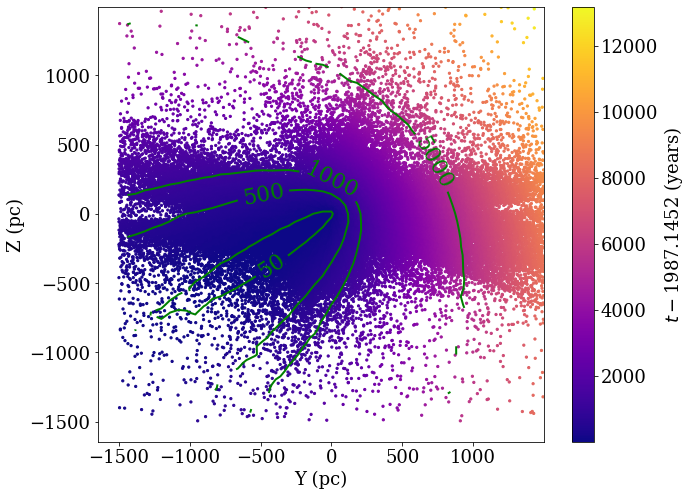

In [32]:
H, xe, ye, bn = binned_statistic_2d(Gaia['y'][x10], Gaia['z'][x10],
                                    values = etime[x10].value, statistic='mean', bins=50)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(10,8))
plt.scatter(Gaia['y'][x10], Gaia['z'][x10],
            c=(etime[x10].value), cmap=plt.cm.plasma, s=5)
cb = plt.colorbar()
cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='g', linewidths=2, levels=[50,500,1000,5000])
plt.clabel(cs, fontsize=22)


plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

In [33]:
# Which stars have crossed the ellipsoid since Gaia begain observing?
gstart = Time('2014.569312182902', format='decimalyear') # first Gaia alert
gstart1987 = (gstart-t0).to('year').value # years between first Gaia alert and date SN 1987A observed on Earth

e7 = ((etime.value >= gstart1987) & # since the first alert
      (etime.value < ((t1-t0).to('year').value+0.1)) # up to 0.1 years from now
     ) 
print('Variable stars that have crossed the ellipsoid since Gaia began observing: ' + str(sum(e7)))

Variable stars that have crossed the ellipsoid since Gaia began observing: 6409


In [34]:
CE7 = SkyCoord(ra=Gaia['ra'][e7], dec=Gaia['dec'][e7], distance=Gaia['dist'][e7], frame = 'icrs')

Text(0, 0.5, 'Z (pc)')

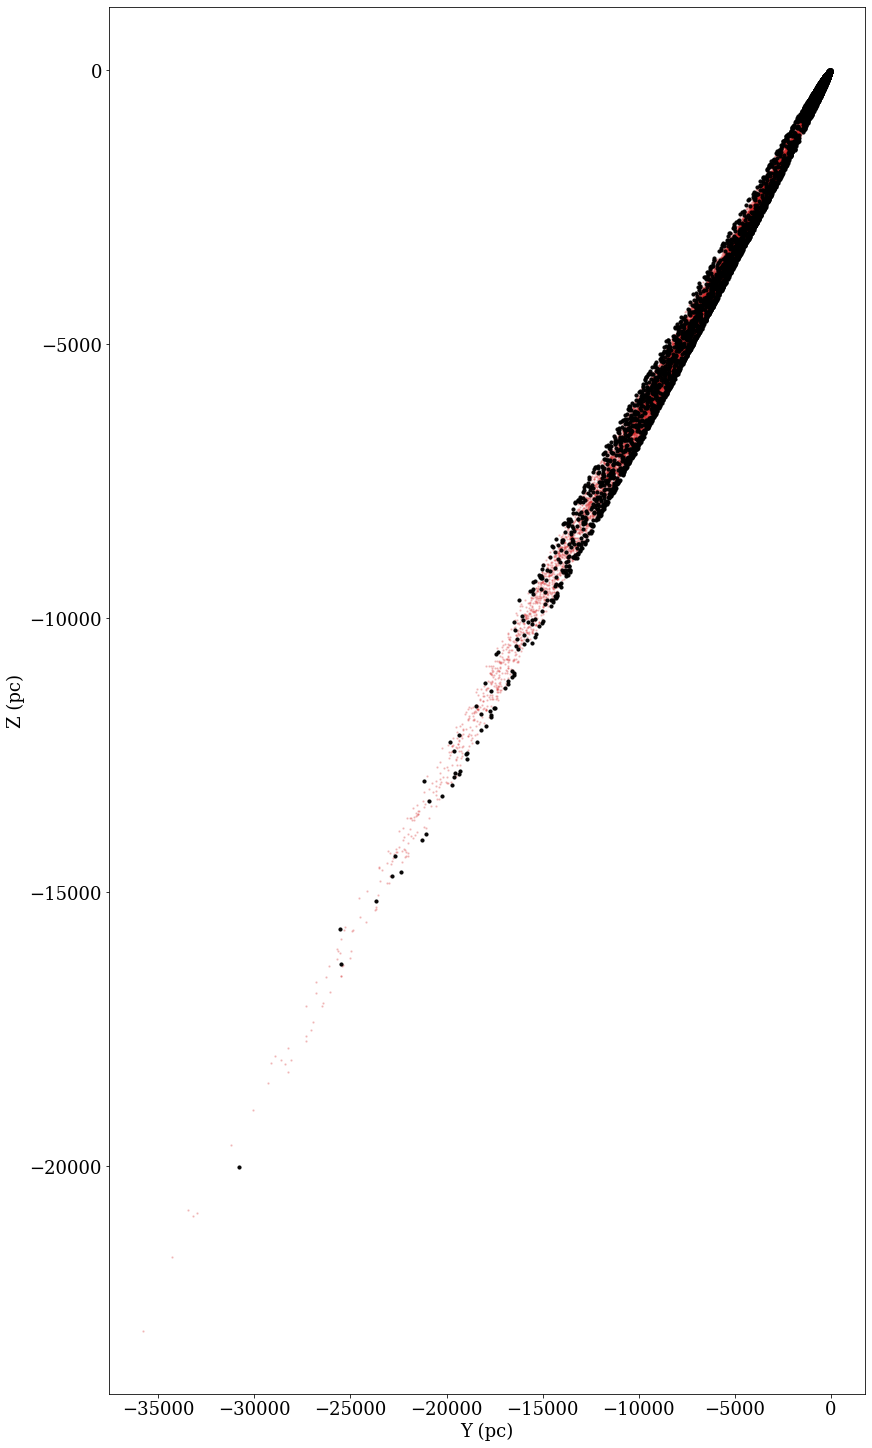

In [35]:
fig = plt.figure(figsize=(12,20), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()


ax.scatter(Gaia['y'][EYES], Gaia['z'][EYES], c='C3', s=2, alpha=0.2, rasterized=True)
ax.scatter(Gaia['y'][e7], Gaia['z'][e7], c='k', s=10, alpha=0.95, rasterized=True)

ax.set_xlabel('Y (pc)')
ax.set_ylabel('Z (pc)')

Black dots above have crossed the SETI Ellipsoid since Gaia's first alert.

Text(0.5, 0, 'Z (pc)')

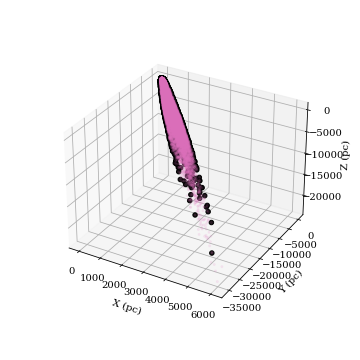

In [36]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Gaia['x'][EYES], Gaia['y'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(Gaia['x'][e7], Gaia['y'][e7], Gaia['z'][e7], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Black points are those that have crossed the ellipse since Gaia has been active

In [37]:
hh, be = np.histogram(etime.value, bins = np.arange(100)) # histogram of crossing times (for 100 years after 1987)

print(f'Average of {np.mean(hh):0.1f} variable stars cross the ellipsoid per year from 1987-2087')
print(f'Median of {np.median(hh):0.1f} variable stars cross the ellipsoid per year from 1987-2087')

Average of 795.3 variable stars cross the ellipsoid per year from 1987-2087
Median of 725.0 variable stars cross the ellipsoid per year from 1987-2087


In [38]:
derror = (((Gaia['dist84'] - Gaia['dist']) + (Gaia['dist'] - Gaia['dist16']))/2).to('lyr')
op = (derror < 0.1*u.lyr)

hh1, be1 = np.histogram(etime[op].value, bins = np.arange(100))

print(f'Average of {np.mean(hh1):0.1f} variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr')
print(f'Median of {np.median(hh1):0.1f} variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr')

Average of 4.5 variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr
Median of 4.0 variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr


#### Statistics

In [39]:
f1 = sum(derror < 1*u.lyr) / len(Gaia)
print(f'Fraction of variable stars in Gaia with distance error < 1 lyr: {f1:0.3f}')

Fraction of variable stars in Gaia with distance error < 1 lyr: 0.005


In [40]:
f2 = sum(derror < 0.1*u.lyr) / len(Gaia)
print(f'Fraction of variable stars in Gaia with distance error < 0.1 lyr: {f2:0.5f}')

Fraction of variable stars in Gaia with distance error < 0.1 lyr: 0.00013


10.490238 16.255114


Text(0.5, 1.0, 'Gaia Variable Stars with Distance Error < 0.1 lyr')

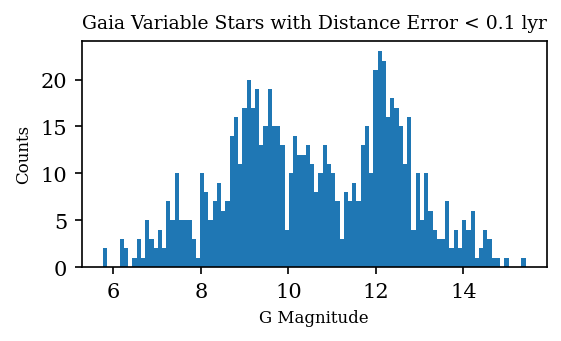

In [41]:
%matplotlib inline
# median magnitudes in G band with distance error < 0.1 lyr and overall
print(np.ma.median(Gaia['g'][derror < 0.1*u.lyr]), np.ma.median(Gaia['g']))


plt.figure(dpi=150, figsize=(4,2))
plt.hist(Gaia['g'][derror < 0.1*u.lyr], bins = 100)
plt.xlabel('G Magnitude', fontsize=8)
plt.ylabel('Counts', fontsize=8)
plt.title('Gaia Variable Stars with Distance Error < 0.1 lyr', fontsize = 9)

Text(0.5, 1.0, 'Crossing Times of Gaia Variable Stars')

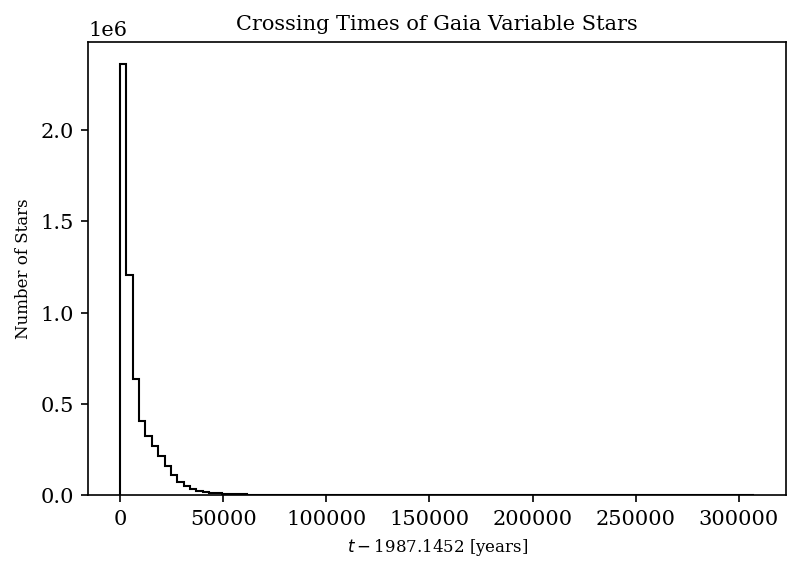

In [45]:
plt.figure(dpi=150, figsize=[6,4])
plt.hist(etime.value, bins=100, histtype='step', density=False, lw=1, color='k')
plt.xlabel(f'$t -${t0.decimalyear:7.4f} [years]', fontsize=8)
plt.ylabel('Number of Stars', fontsize=8)
plt.title('Crossing Times of Gaia Variable Stars', fontsize=10)

In [46]:
len(Gaia) / (np.pi * ((100 * u.pc).to('lyr'))**3)

<Quantity 0.05451434 1 / lyr3>

In [47]:
from scipy.stats import mode

def mmode(x):
    return mode(x)[0][0] # mode value (mode count is mode(x)[1][0]

def mmax(x):
    hh, be = np.histogram(x, bins=100)
    
    return(((be[1:]+be[0:-1])/2)[np.argmax(hh)]) 
    # returns the center of the bin (halfway between the bin edges) with the maximum count

In [57]:
((((Gaia['dist84']-Gaia['dist']) + (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value)

array([ 245.67613 , 2718.1018  ,   72.837845, ...,  169.65964 ,
         66.83528 ,  291.67566 ], dtype=float32)

(0.0, 326.15637771674335)

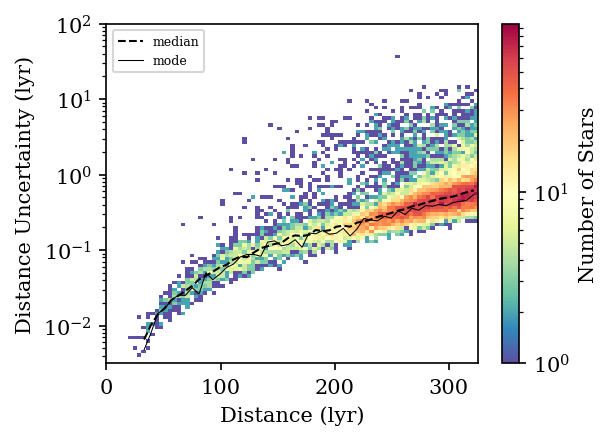

In [61]:
plt.figure(dpi=150,figsize=(4,3))
plt.hist2d((Gaia['dist']).to('lyr').value, 
           (((Gaia['dist84']-Gaia['dist']) + (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value,
           bins=[np.linspace(0,380,100), np.logspace(-2.5,2,100)],
           cmap=plt.cm.Spectral_r, norm=LogNorm())
# ((dist_84 - dist_50) + (dist_50 - dist_16))/2 is the standard deviation/error

cb = plt.colorbar()
cb.set_label('Number of Stars')

uncertainty = (((Gaia['dist84']-Gaia['dist']) + 
                                        (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value
dists = Gaia['dist'].to('lyr').value

# bin_means, bin_edges, bin_number
H1, xe, bn = binned_statistic(dists[~np.isnan(dists)],
                              values=uncertainty[~np.isnan(uncertainty)],
                              statistic='median', bins=np.linspace(30,325,50))
plt.plot((xe[1:] + xe[0:-1])/2, H1, c='k', lw=1, ls='--', label='median')

H2, xe, bn = binned_statistic(dists[~np.isnan(dists)],
                              values=uncertainty[~np.isnan(uncertainty)],
                                statistic=mmax, bins=np.linspace(30,325,50))
plt.plot((xe[1:] + xe[0:-1])/2, H2, c='k', lw=0.5, label='mode')

plt.xlabel('Distance (lyr)')
plt.ylabel('Distance Uncertainty (lyr)')
plt.yscale('log')
plt.legend(fontsize=6, loc='upper left')

plt.xlim(0, (100*u.pc).to('lyr').value)

Text(0.5, 1.0, 'Distance Uncertainty Histogram of Stars Between 200-220 lyr')

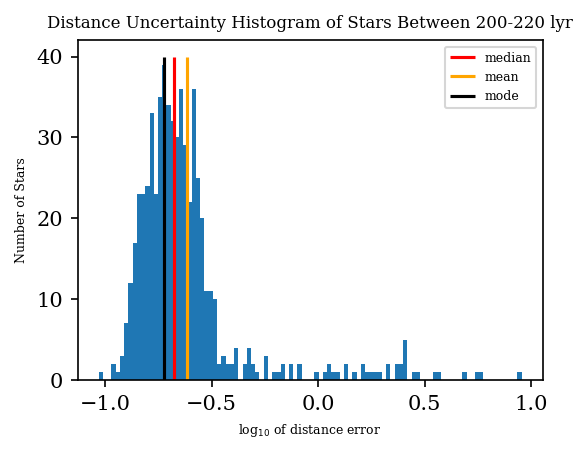

In [63]:
plt.figure(dpi=150, figsize=(4,3))

xr = ((Gaia['dist']).to('lyr').value > 200) & ((Gaia['dist']).to('lyr').value < 220)
plt.hist(np.log10(((((Gaia['dist84']-Gaia['dist']) + 
                    (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value)[xr]), bins=100)
plt.vlines(np.median(np.log10(((((Gaia['dist84']-Gaia['dist']) + 
                               (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value)[xr])),
            0, 40, color='r', label='median')

plt.vlines(np.mean(np.log10(((((Gaia['dist84']-Gaia['dist']) + 
                                (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value)[xr])),
            0, 40, color='orange', label='mean')

plt.vlines(mmax(np.log10(((((Gaia['dist84']-Gaia['dist']) + 
                                (Gaia['dist']-Gaia['dist16']))/2.).to('lyr').value)[xr])),
            0, 40, color='k', label='mode')

plt.legend(fontsize=6, loc='upper right')
plt.xlabel('log$_{10}$ of distance error', fontsize=6)
plt.ylabel('Number of Stars', fontsize=6)
plt.title('Distance Uncertainty Histogram of Stars Between 200-220 lyr', fontsize=8)

#### CMD of Variable Stars in Gaia that have crossed the ellipsoid since Gaia began observing

In [64]:
brcol = Gaia['bp'][e7] - Gaia['rp'][e7]
mag = Gaia['g'][e7]
absmag = mag - 5.*np.log10(Gaia['dist'][e7]) + 5.

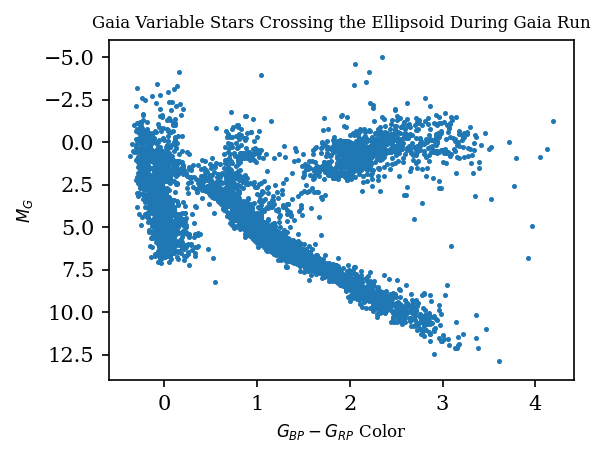

In [68]:
%matplotlib inline
plt.figure(dpi=150,figsize=(4,3))

plt.scatter(brcol.value, absmag.value, s=2)
plt.ylim(14, -6)
plt.title('Gaia Variable Stars Crossing the Ellipsoid During Gaia Run', fontsize=8)
plt.xlabel('$G_{BP} - G_{RP}$ Color', fontsize=8)
plt.ylabel('$M_G$', fontsize=8)

plt.savefig('CMD1_Gaia', transparent=False, facecolor='white')